In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
)

## 0. Index

- 1. Carregando e validando os dados
    Carregamento dos dados originais e analise simples dos dados

- 2. DataFrame tratado para EDA
    Copia do DF original para realizar EDA, podendo ser alterado conforme necessario

- 3. Pipeline ML
    Preparacao dos dados e execucao dos modelos com copia separada do DF original

## 1. Carregando e validando os dados

In [2]:
df = pd.read_csv('../../data/Obesity.csv')

In [3]:
df.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.isnull().sum()

gender            0
age               0
height            0
weight            0
family_history    0
favc              0
fcvc              0
ncp               0
caec              0
smoke             0
ch2o              0
scc               0
faf               0
tue               0
calc              0
mtrans            0
obesity           0
dtype: int64

In [6]:
df['obesity'].unique()

array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

In [7]:
df['caec'].unique()

array(['Sometimes', 'Frequently', 'Always', 'no'], dtype=object)

In [8]:
df['mtrans'].unique()

array(['Public_Transportation', 'Walking', 'Automobile', 'Motorbike',
       'Bike'], dtype=object)

In [9]:
df['calc'].unique()

array(['no', 'Sometimes', 'Frequently', 'Always'], dtype=object)

In [10]:
df['tue'].unique()

array([1.      , 0.      , 2.      , ..., 0.646288, 0.586035, 0.714137],
      shape=(1129,))

In [11]:
for col in df.columns:
    if col in ['fcvc', 'ncp']:
        continue
    print(f"Coluna {col}:", df[col].unique())

Coluna gender: ['Female' 'Male']
Coluna age: [21.       23.       27.       ... 22.524036 24.361936 23.664709]
Coluna height: [1.62     1.52     1.8      ... 1.752206 1.73945  1.738836]
Coluna weight: [ 64.        56.        77.       ... 133.689352 133.346641 133.472641]
Coluna family_history: ['yes' 'no']
Coluna favc: ['no' 'yes']
Coluna caec: ['Sometimes' 'Frequently' 'Always' 'no']
Coluna smoke: ['no' 'yes']
Coluna ch2o: [2.       3.       1.       ... 2.054193 2.852339 2.863513]
Coluna scc: ['no' 'yes']
Coluna faf: [0.       3.       2.       ... 1.414209 1.139107 1.026452]
Coluna tue: [1.       0.       2.       ... 0.646288 0.586035 0.714137]
Coluna calc: ['no' 'Sometimes' 'Frequently' 'Always']
Coluna mtrans: ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
Coluna obesity: ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


In [12]:
df['obesity'].groupby(df['obesity']).count()

obesity
Insufficient_Weight    272
Normal_Weight          287
Obesity_Type_I         351
Obesity_Type_II        297
Obesity_Type_III       324
Overweight_Level_I     290
Overweight_Level_II    290
Name: obesity, dtype: int64

In [13]:
df.describe()

,age,height,weight,fcvc,ncp,ch2o,faf,tue
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


## 2. DataFrame tratado para EDA

In [14]:
df_tratado = df.copy()

df_tratado.head()

,gender,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


### Tratando ordinais

In [15]:
encoder_orders = {
    "obesity": ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'],
    "caec": ["no", "Sometimes", "Frequently", "Always"],
    "calc": ["no", "Sometimes", "Frequently", "Always"]
}

categorias = list(encoder_orders.values())
original_cols = list(encoder_orders.keys())
encoded_cols = [col + '_encoded' for col in list(encoder_orders.keys())]

ord_encoder = OrdinalEncoder(categories=categorias)
encoded_cols_result = ord_encoder.fit_transform(df_tratado[original_cols])
df_tratado[encoded_cols] = encoded_cols_result

df_tratado.head()

,gender,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,obesity,obesity_encoded,caec_encoded,calc_encoded
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,1.0,1.0,0.0
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,1.0,1.0,1.0
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,1.0,1.0,2.0
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,2.0,1.0,2.0
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,3.0,1.0,1.0


### Tratando binarios

In [16]:
bool_cols = [
    'family_history',
    'scc',
    'smoke'
]  

bool_cols_name = list(map(lambda c: c + '_bool', bool_cols))

df_tratado[bool_cols_name] = df_tratado[bool_cols].replace({'yes': 1, 'no': 0})

df_tratado.head()

C:\Users\Arthur\AppData\Local\Temp\ipykernel_19096\1389549500.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tratado[bool_cols_name] = df_tratado[bool_cols].replace({'yes': 1, 'no': 0})


,gender,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,...,tue,calc,mtrans,obesity,obesity_encoded,caec_encoded,calc_encoded,family_history_bool,scc_bool,smoke_bool
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,...,1.0,no,Public_Transportation,Normal_Weight,1.0,1.0,0.0,1,0,0
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,...,0.0,Sometimes,Public_Transportation,Normal_Weight,1.0,1.0,1.0,1,1,1
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,...,1.0,Frequently,Public_Transportation,Normal_Weight,1.0,1.0,2.0,1,0,0
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,...,0.0,Frequently,Walking,Overweight_Level_I,2.0,1.0,2.0,0,0,0
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,...,0.0,Sometimes,Public_Transportation,Overweight_Level_II,3.0,1.0,1.0,0,0,0


### Tratando categoricas

In [17]:
cat_cols = [
    'gender',
    'mtrans'
]

df_tratado = pd.get_dummies(df_tratado, columns=cat_cols, dtype=int)

df_tratado.head()

,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,...,family_history_bool,scc_bool,smoke_bool,gender_Female,gender_Male,mtrans_Automobile,mtrans_Bike,mtrans_Motorbike,mtrans_Public_Transportation,mtrans_Walking
0,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,...,1,0,0,1,0,0,0,0,1,0
1,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,...,1,1,1,1,0,0,0,0,1,0
2,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,...,1,0,0,0,1,0,0,0,1,0
3,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,...,0,0,0,0,1,0,0,0,0,1
4,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,...,0,0,0,0,1,0,0,0,1,0


In [18]:
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           2111 non-null   float64
 1   height                        2111 non-null   float64
 2   weight                        2111 non-null   float64
 3   family_history                2111 non-null   object 
 4   favc                          2111 non-null   object 
 5   fcvc                          2111 non-null   float64
 6   ncp                           2111 non-null   float64
 7   caec                          2111 non-null   object 
 8   smoke                         2111 non-null   object 
 9   ch2o                          2111 non-null   float64
 10  scc                           2111 non-null   object 
 11  faf                           2111 non-null   float64
 12  tue                           2111 non-null   float64
 13  cal

In [19]:
df_tratado.head()

,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,...,family_history_bool,scc_bool,smoke_bool,gender_Female,gender_Male,mtrans_Automobile,mtrans_Bike,mtrans_Motorbike,mtrans_Public_Transportation,mtrans_Walking
0,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,...,1,0,0,1,0,0,0,0,1,0
1,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,...,1,1,1,1,0,0,0,0,1,0
2,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,...,1,0,0,0,1,0,0,0,1,0
3,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,...,0,0,0,0,1,0,0,0,0,1
4,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,...,0,0,0,0,1,0,0,0,1,0


In [20]:
df_tratado['smoke_bool'].value_counts()

smoke_bool
0    2067
1      44
Name: count, dtype: int64

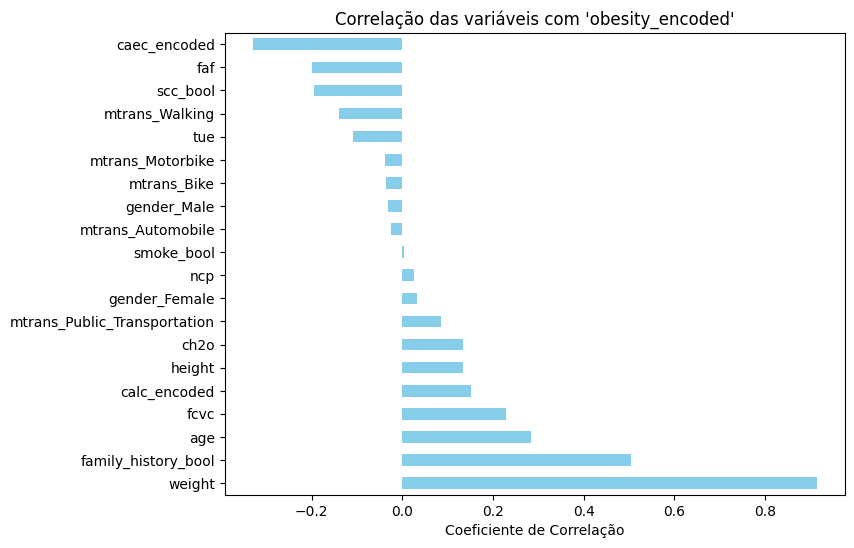

In [21]:
target = 'obesity_encoded'
corr = df_tratado.corr(numeric_only=True)[target].drop(target).sort_values(ascending=False)

plt.figure(figsize=(8,6))
corr.plot(kind='barh', color='skyblue')
plt.xlabel("Coeficiente de Correlação")
plt.title(f"Correlação das variáveis com '{target}'")
plt.show()


## 3. Pipeline ML

### 3.1 Pipeline 1 - Target com valores originais

#### Dataset usado no modelo

In [22]:
df_model_01 = df.copy()

#### Preprocessamento

In [23]:
target_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

ord_cols_encoder_orders = {
    #"obesity": ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'],
    "caec": ["no", "Sometimes", "Frequently", "Always"],
    "calc": ["no", "Sometimes", "Frequently", "Always"]
}

ord_cols = list(ord_cols_encoder_orders.keys())

bool_cols = [
    'family_history',
    'scc',
    'smoke'
]

onehot_cols = [
    'gender',
    'mtrans'
]

In [24]:
# Target encoder
target_encoder = OrdinalEncoder(categories=[target_order])

# Ordinal encoder
categorias = list(ord_cols_encoder_orders.values())

ord_trns = OrdinalEncoder(categories=categorias)

# OneHot encoder
onehot_trns = OneHotEncoder(handle_unknown="ignore")

# Processing boolean columnms
def bool_transformer(X):
    return np.where(X == "yes", 1, 0)

bool_trns = FunctionTransformer(bool_transformer)

In [25]:
target_encoder.fit_transform(df[["obesity"]])

array([[1.],
       [1.],
       [1.],
       ...,
       [6.],
       [6.],
       [6.]], shape=(2111, 1))

In [26]:
preprocessor_01 = ColumnTransformer([
    ("ordinais", ord_trns, ord_cols),
    ("nominais", onehot_trns, onehot_cols),
    ("binarias", bool_trns, bool_cols)
    #("numericas", scaler, numeric_cols)
])

In [27]:
model_01 = Pipeline([
    ("preprocessing", preprocessor_01),
    ("classifier", LogisticRegression(max_iter=1000))
])

In [28]:
features_selecionadas = [
    'caec',
    'faf',
    'scc',
    'tue',
    'calc',
    'fcvc',
    'age',
    'family_history',
    'weight'
]

# TODO: Selecionar melhores features e retirar comentario 
#       da proxima linha
#X = df_model[features_selecionadas]
X = df_model_01.drop(columns=["obesity"])
y = df_model_01["obesity"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [29]:
# Treinar o modelo
model_01.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ordinais', ...), ('nominais', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [31]:
y_pred = model_01.predict(X_test)

print("🔹 Acurácia:", accuracy_score(y_test, y_pred))
print("🔹 F1 Score:", f1_score(y_test, y_pred, average='macro'))
#print("🔹 ROC AUC:", roc_auc_score(y_test, y_proba, multi_class='ovr'))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


🔹 Acurácia: 0.5035460992907801
🔹 F1 Score: 0.4414979294763661

Matriz de Confusão:
 [[30  8  1 15  0  0  0]
 [15 24  2  5  7  5  0]
 [ 1  3 39 19  8  0  0]
 [ 0  4 10 45  0  1  0]
 [ 0  1  0  0 64  0  0]
 [ 6  6 11 13 11 11  0]
 [ 4  2 17 28  5  2  0]]

Relatório de Classificação:
                      precision    recall  f1-score   support

Insufficient_Weight       0.54      0.56      0.55        54
      Normal_Weight       0.50      0.41      0.45        58
     Obesity_Type_I       0.49      0.56      0.52        70
    Obesity_Type_II       0.36      0.75      0.49        60
   Obesity_Type_III       0.67      0.98      0.80        65
 Overweight_Level_I       0.58      0.19      0.29        58
Overweight_Level_II       0.00      0.00      0.00        58

           accuracy                           0.50       423
          macro avg       0.45      0.49      0.44       423
       weighted avg       0.45      0.50      0.45       423



c:\Users\Arthur\Desktop\POS\Tech4\fiap-tech4\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Arthur\Desktop\POS\Tech4\fiap-tech4\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Arthur\Desktop\POS\Tech4\fiap-tech4\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

### 3.2 Pipeline 2 - Target binária

#### Dataset

In [32]:
df_model_02 = df.copy()

In [33]:
ord_cols_encoder_orders = {
    "caec": ["no", "Sometimes", "Frequently", "Always"],
    "calc": ["no", "Sometimes", "Frequently", "Always"]
}

ord_cols = list(ord_cols_encoder_orders.keys())

bool_cols = [
    'family_history',
    'scc',
    'smoke'
]

onehot_cols = [
    'gender',
    'mtrans'
]

In [34]:
# Ordinal encoder
categorias = list(ord_cols_encoder_orders.values())

ord_trns = OrdinalEncoder(categories=categorias)

# OneHot encoder
onehot_trns = OneHotEncoder(handle_unknown="ignore")

# Processing boolean columnms
def bool_transformer(X):
    return np.where(X == "yes", 1, 0)

bool_trns = FunctionTransformer(bool_transformer)

In [35]:
obesity_values = ['Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
df_model_02['target'] = np.where(df_model_02['obesity'].isin(obesity_values), 1, 0)

In [36]:
preprocessor_02 = ColumnTransformer([
    ("ordinais", ord_trns, ord_cols),
    ("nominais", onehot_trns, onehot_cols),
    ("binarias", bool_trns, bool_cols)
    #("numericas", scaler, numeric_cols)
])

model_02 = Pipeline([
    ("preprocessing", preprocessor_01),
    ("classifier", LogisticRegression(max_iter=1000))
])

In [40]:
features_selecionadas = [
    'caec',
    'faf',
    'scc',
    'tue',
    'calc',
    'fcvc',
    'age',
    'family_history',
    'weight',
    'smoke',
    'gender',
    'mtrans'
]

# TODO: Selecionar melhores features e retirar comentario 
#       da proxima linha
X = df_model_02[features_selecionadas]
y = df_model_02["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [41]:
# Treinar o modelo
model_02.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ordinais', ...), ('nominais', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [42]:
y_pred = model_02.predict(X_test)

print("🔹 Acurácia:", accuracy_score(y_test, y_pred))
print("🔹 F1 Score:", f1_score(y_test, y_pred, average='macro'))
#print("🔹 ROC AUC:", roc_auc_score(y_test, y_proba, multi_class='ovr'))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


🔹 Acurácia: 0.7375886524822695
🔹 F1 Score: 0.7335622074053056

Matriz de Confusão:
 [[130  98]
 [ 13 182]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.91      0.57      0.70       228
           1       0.65      0.93      0.77       195

    accuracy                           0.74       423
   macro avg       0.78      0.75      0.73       423
weighted avg       0.79      0.74      0.73       423

